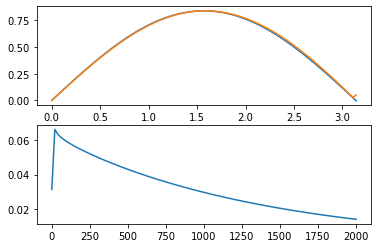

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import tkinter as tk
import tkinter.ttk as ttk

a = 0.5
b = 24
c = - 312
l = np.pi
N = 100
K = 2001

alpha0 = 1
alphal = 1
betta0 = 1
bettal = 1

# Граничные условия
phi0 = lambda t: np.exp((c - a) * t)
phil = lambda t: np.exp((c - a) * t)

# Начальные условия
gamma0 = lambda x: np.sin(x)

# Аналитическое решение
fResult = lambda x, t: np.exp((c - a) * t) * np.sin(x + b * t)

h = l / N
sigma = 0.4
taw = sigma * h ** 2 / a
mu = b * taw / 2 / h
U = []


def plotSlice(f, X, t):
    plt.subplot(2, 1, 1)
    plt.plot(X, f(X, t))
    plt.grid


def Error(U, fR, count):
    X = np.linspace(0, l, N)
    Y = list(map(int, np.linspace(0, U.shape[0] - 1, count)))
    plt.subplot(2, 1, 2)
    plt.plot(Y, list(map(lambda tt: np.max(np.abs(U[tt] - fR(X, taw*tt))), Y)))


def gridFun(xCond, tCond):
    xlCond,xrCond = xCond
    tlCond, trCond = tCond
    return np.zeros((xrCond, trCond))


# Явная конечно-разностная схема
def explicitMethod(iCondition, bCondition, method="1"):

    def explicitWithFirstDegree():
        # 1 порядка
        for k in range(0, K - 1):
            U[k + 1][0] = (- alpha0 / h * U[k + 1][1] + phi0(taw * (k + 1))) / (betta0 - alpha0 / h)
            U[k + 1][N - 1] = (alphal / h * U[k + 1][N - 2] + phil(taw * (k + 1))) / (bettal + alphal / h)
        pass

    def explicitWithSecondDegree():
        # 2 порядка
        for k in range(0, K - 1):
            U[k + 1][0] = (- alpha0 / h / 2 * (4 * U[k + 1][1] - U[k + 1][2]) + phi0(taw * (k + 1))) / (
            betta0 - 3 * alpha0 / h / 2)
            U[k + 1][N - 1] = (- alphal / h / 2 * (U[k + 1][N - 3] - 4 * U[k + 1][N - 2]) + phil(taw * (k + 1))) / (
            bettal + 3 * alphal / h / 2)

    def explicitWithThirdDegree():
        b0 = 2*a/h + h/taw - h*c - betta0/alpha0*(2*a - b*h)
        c0 = -2*a/h
        bN = 2*a/h + h/taw - h*c + bettal/alphal*(2*a + b*h)
        aN = -2*a/h
        for k in range(0, K - 1):
            d0 = h/taw * U[k][0] - phi0(taw*(k + 1)) * (2*a - b*h) / alpha0
            dN = h/taw * U[k][N - 1] + phil(taw*(k + 1)) * (2*a + b*h) / alphal
            U[k + 1][0] = (d0 - c0 * U[k + 1][1]) / b0
            U[k + 1][N - 1] = (dN - aN * U[k + 1][N - 2]) / bN

    gamma0 = iCondition
    phi0, phil = bCondition
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)
    for k in range(0, K - 1):
        for j in range(1, N - 1):
            U[k + 1][j] = (sigma + mu) * U[k][j + 1] + (1 - 2 * sigma + taw * c) * U[k][j] + (sigma - mu) * U[k][
                j - 1]
            pass
    if method == "1":
        explicitWithFirstDegree()
    elif method == "2":
        explicitWithSecondDegree()
    elif method == "3":
        explicitWithThirdDegree()
    else:
        pass
    return U


# Неявный метод
def implicitMethod(iCondition, bCondition, method="1"):
    def implicitWithFirstDegree():
        b0 = betta0 - alpha0 / h
        c0 = alpha0 / h
        aN = - alphal / h
        bN = bettal + alphal / h

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb
        return gA, gB

    def implicitWithSecondDegree():
        a0 = betta0 - 3*alpha0/ h/ 2
        b0 = 2 * alpha0/h
        c0 = - alpha0 / h /2
        aN = alphal / h /2
        bN = -2 * alphal/h
        cN = bettal + 3*alphal/ h/ 2

        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = a0
            aa[0][1] = b0
            aa[0][2] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = bN
            aa[N - 1][N - 1] = cN
            aa[N - 1][N - 3] = aN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            bb[0][0] = phi0(taw * (k + 1))
            bb[N - 1][0] = phil(taw * (k + 1))
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb
        return gA, gB

    def implicitWithThirdDegree():
        b0 = 2 * a / h + h / taw - h * c - betta0 / alpha0 * (2 * a - b * h)
        c0 = -2 * a / h
        bN = 2 * a / h + h / taw - h * c + bettal / alphal * (2 * a + b * h)
        aN = -2 * a / h
        def gA():
            aa = np.zeros((N, N))
            aa[0][0] = b0
            aa[0][1] = c0
            for j in range(1, N - 1):
                aa[j][j - 1] = aj
                aa[j][j] = bj
                aa[j][j + 1] = cj
            aa[N - 1][N - 2] = aN
            aa[N - 1][N - 1] = bN
            return aa

        def gB(k):
            bb = np.zeros((N, 1))
            d0 = h / taw * U[k][0] - phi0(taw * (k + 1)) * (2 * a - b * h) / alpha0
            dN = h / taw * U[k][N - 1] + phil(taw * (k + 1)) * (2 * a + b * h) / alphal
            bb[0][0] = d0
            bb[N - 1][0] = dN
            for j in range(1, N - 1):
                bb[j][0] = - U[k][j]
            return bb

        return gA, gB

    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)
    aj = a * taw / h ** 2 - taw * b / 2 / h
    bj = taw * (c - 2 * a / h ** 2) - 1
    cj = a * taw / h ** 2 + taw * b / 2 / h
    if method == "1":
        getA, getB = implicitWithFirstDegree()
    elif method == "2":
        getA, getB = implicitWithSecondDegree()
    elif method == "3":
        getA, getB = implicitWithThirdDegree()
    else:
        return U
    A = getA()
    for k in range(0, K - 1):
        B = getB(k)
        U[k + 1] = np.linalg.solve(A, B)[:, 0]

    return U


# Схема Кранка-Николсона
def CrankNicolsonMethod(iCondition, bCondition, sgm):
    U = gridFun((0, K), (0, N))
    for j in range(0, N):
        U[0][j] = gamma0(j * h)

    aj = sgm * a * taw / h ** 2 - taw * b / 2 / h
    bj = taw * (c - sgm * 2 * a / h ** 2) - 1
    cj = sgm * a * taw / h ** 2 + taw * b / 2 / h

    a0 = betta0 - 3 * alpha0 / h / 2
    b0 = 2 * alpha0 / h
    c0 = - alpha0 / h / 2
    aN = alphal / h / 2
    bN = -2 * alphal / h
    cN = bettal + 3 * alphal / h / 2
    def getA():
        a = np.zeros((N, N))
        a[0][0] = a0
        a[0][1] = b0
        a[0][2] = c0
        for j in range(1, N - 1):
            a[j][j - 1] = aj
            a[j][j] = bj
            a[j][j + 1] = cj
        a[N - 1][N - 3] = aN
        a[N - 1][N - 2] = bN
        a[N - 1][N - 1] = cN
        return a

    def getB(k):
        b = np.zeros((N, 1))
        b[0][0] = phi0(taw * (k + 1))
        b[N - 1][0] = phil(taw * (k + 1))
        for j in range(1, N - 1):
            b[j][0] = - U[k][j] - (1 - sgm)*(a * taw /h ** 2) * (U[k][j + 1] - 2*U[k][j] + U[k][j - 1])
        return b

    A = getA()
    for k in range(0, K - 1):
        B = getB(k)
        U[k + 1] = np.linalg.solve(A, B)[:, 0]
    return U


def showPostProcess(t):
    X = np.linspace(0, l, N)
    plotSlice(fResult, X, taw * t)
    plt.subplot(2, 1, 1)
    plt.plot(X, U[t])


def solver():
    global a, b, c, N, K, h, l, sigma, taw, mu, U, tt
    a = float(entrya.get())
    b = float(entryb.get())
    c = float(entryc.get())
    N = int(scaleh.get())*10
    tt = int(t0.get())
    sigma = float(scaleT.get())
    h = l / N
    taw = sigma * h ** 2 / a
    mu = b * taw / 2 / h
    U = []
    method = combobox.get()
    variation = combobox1.get()
    if variation == "Двухточечная с первым порядком":
        var = "1"
    elif variation == "Трехточечная со вторым порядком":
        var = "2"
    elif variation == "Двухточечная со вторым порядком":
        var = "3"
    else:
        return 0
    if method == "Явный":
        U = explicitMethod(gamma0,(phi0,phil),var)
    elif method == "Неявный":
        U = implicitMethod(gamma0, (phi0, phil), var)
    elif method == "Кранка-Николсона":
        U = CrankNicolsonMethod(gamma0, (phi0, phil), 0.5)
    else:
        return 0
    showPostProcess(tt)
    Error(U, fResult, 100)
    plt.show()



root = tk.Tk()
root.title("Лабораторная работа №1")
frame = ttk.Frame(root)
frame.grid()
combobox = ttk.Combobox(frame, values=["Явный", "Неявный", "Кранка-Николсона"], height=3, width=50)
combobox1 = ttk.Combobox(frame, values=["Двухточечная с первым порядком", "Трехточечная со вторым порядком", "Двухточечная со вторым порядком"], height=3, width=50)
button = ttk.Button(root,text="Решить", command=solver)
# image = tk.PhotoImage(file="task.PNG")
# lab = ttk.Label(frame,image=image)
lab0 = ttk.Label(frame,text="Выберите метод")
labgrid = ttk.Label(frame,text="Выберите параметры сетки")
labtask = ttk.Label(frame,text="Выберите параметры задачи:\n\ta>0,b>0,c<0")
sliceTask = ttk.Label(frame,text="Выберите сечение по времени")
lab1 = ttk.Label(frame, text = "Выберите порядок \nапроксимации граничного условия")
scaleh = tk.Scale(frame,orient=tk.HORIZONTAL,length=200,from_=0,tickinterval=20,resolution=1,to=100)
scaleT = tk.Scale(frame,orient=tk.HORIZONTAL,length=200,from_=0,tickinterval=0.2,resolution=0.01,to=1)
scaleh.set(10)
scaleT.set(0.35)
entrya = tk.Entry(frame,width=10,bd=10)
entryb = tk.Entry(frame,width=10,bd=10)
entryc = tk.Entry(frame,width=10,bd=10)
t0 = tk.Entry(frame, width=10,bd=10)
t0.insert(0,200)
entrya.insert(0,12)
entryb.insert(0,0.4)
entryc.insert(0,-19)
combobox.set("Явный")
combobox1.set("Двухточечная с первым порядком")
timeSlice = ttk.Label(frame,text="t0\t=",font="arial 20")
labtaska = ttk.Label(frame,text="a\t=",font="arial 20")
labtaskb = ttk.Label(frame,text="b\t=",font="arial 20")
labtaskc = ttk.Label(frame,text="c\t=",font="arial 20")
labgridh = ttk.Label(frame,text="N\t=",font="arial 20")
labgridt = ttk.Label(frame,text="sigma\t=",font="arial 20")
labelgrid0 = ttk.Label(frame,background='#cc0')

#lab.grid(row=0, column=0, columnspan=3)
labtask.grid(row=1, column=0)
labtaska.grid(row=1, column=1)
labtaskb.grid(row=2, column=1)
labtaskc.grid(row=3, column=1)
entrya.grid(row=1, column=2)
entryb.grid(row=2, column=2)
entryc.grid(row=3, column=2)
labgrid.grid(row=4,column=0)
labgridh.grid(row=4, column=1)
labgridt.grid(row=5, column=1)
scaleh.grid(row=4, column=2)
scaleT.grid(row=5, column=2)
sliceTask.grid(row=6, column=0)
t0.grid(row=6, column=1)

lab0.grid(row=8, column=0)
combobox.grid(row=8, column=1)

lab1.grid(row=10, column=0)
combobox1.grid(row=10, column=1)
button.grid(row=11, column=0)

style = ttk.Style()
style.configure("TLabel", padding=3, background='#bb2', font="arial 12", foreground="black")
style.configure("TFrame", background='#CC0')
style.configure("TButton", width=20, height=5, font="arial 20", foreground='red')
root.mainloop()
